In [1]:
import matplotlib
import librosa 
import matplotlib.pyplot as plt ## For plots and visual data
import IPython.display as ipd ## For displaying audio widgets
import lightkurve as lk ## For generation of light curves
import matplotlib.pyplot as plt ## Standard visual data creation module
import librosa.display
import numpy as np
import os
import pandas as pd
import sqlite3 ## Database creation
import mysql.connector
import jupyterthemes
import math
import matplotlib.animation as animation
import random
import ffmpeg
import sys
import datetime
sys.stdout = open(1, 'w')

from astronify.series import SoniSeries ## For sonifying the data
from lightkurve import search_targetpixelfile ## 2D pixel heatmaps etc.
from astropy.io import fits
from astropy.table import Table
from astronify import simulator, series
from celluloid import Camera
from pathlib import Path

## Setting light curve parameters

In [17]:
snr = [3,5,7,10,30,100] ## The signal to noise ratio we are testing for
transit_length = 1000 ## Affects length of sonification
t_depth = 25
width_param = 0.1 ## Transit length as fraction of total
transit_n = [1,2] ## Number of transits we want in the data

In [18]:
noise_sd = []
for x in snr:
    noise_sd.append(np.sqrt(width_param*transit_length)*t_depth/x) 
    ## The actual noise sigma values we put into the simulator. 
    
freq_param = []
for x in transit_n:
    freq_param.append(transit_length/x)
    
print("Standard deviations of noise to put in are:", noise_sd)
print("Transit periods:", freq_param)

In [ ]:
#Fixed Parameters

l_length = 1000
t_width = 100


#Variable Parameters
n_transit = 1
snr = 100

#Calculations needed for current set parameters
l_noise = np.sqrt(t_width)*t_depth/snr 
t_period = l_length/n_transit
#for one transit start at ~half-way point, for two transits start at ~quarter way point
t_start = l_length/(2.*n_transit)-t_width/2. + random.randint(-1*t_period/4, t_period/4) 

lc_data = simulator.simulated_lc("transit", visualize=True, transit_depth=t_depth, transit_period=t_period,
                                 transit_width=t_width, lc_noise=l_noise, lc_length=l_length,transit_start=t_start)

print("Hello")
print(len(lc_data))

## Building database of the parameters for reference

In [23]:
del df ## Running to delete the previous entries and recreate the dataframe
df= pd.DataFrame({'Number of transits': [],
        'Value of SNR': [],
                 'Tag': []})

df
print(df)

## Light curve generator

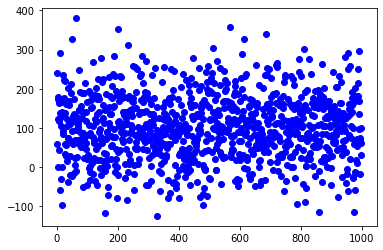

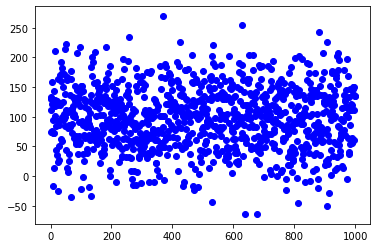

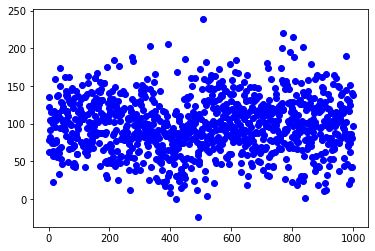

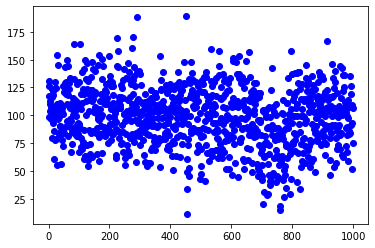

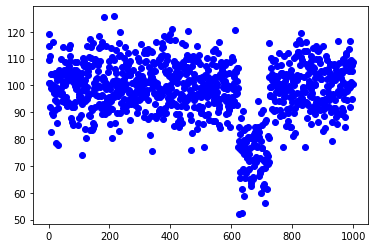

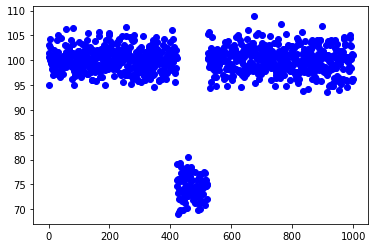

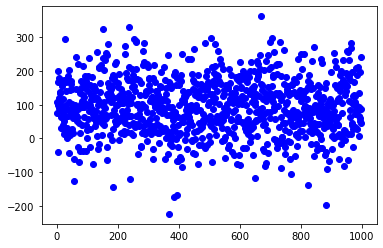

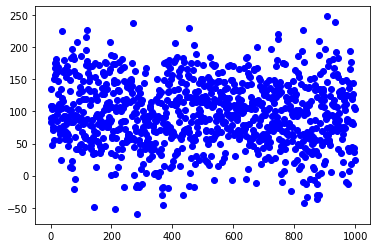

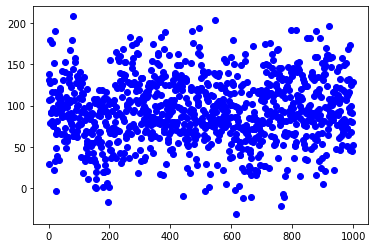

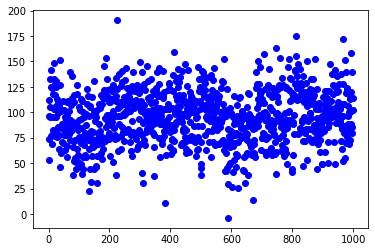

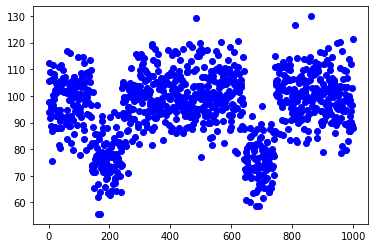

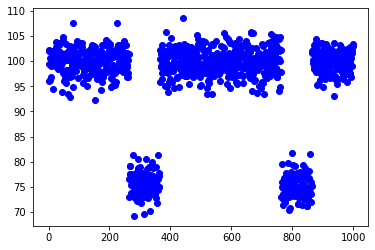

In [24]:
for j in transit_n: ## Generating 12 transits for n = 1, n = 2
                   
    for i in noise_sd:

        t_start = int(transit_length/(2.*j)-(transit_length*width_param)/2. + 
                      random.randint(-1*(transit_length/j)/4, (transit_length/j)/4)) 
        
        k = int(random.uniform(0,100))
        
        lc_data_transit = simulator.simulated_lc("transit", 
                                         visualize = True, 
                                         transit_depth = 25,
                                         transit_period = transit_length/j, 
                                         transit_width = int(transit_length*width_param),
                                         transit_start = t_start,
                                         lc_noise = i, 
                                         lc_length = transit_length)


        lc_sound_transit = series.SoniSeries(lc_data_transit)
        lc_sound_transit.pitch_mapper.pitch_map_args["stretch"] = 'linear'
        lc_sound_transit.pitch_mapper.pitch_map_args["pitch_range"] = [440,880]
        lc_sound_transit_spacing = 0.01
        lc_sound_transit.note_duration = 0.2
        lc_sound_transit.sonify()
        #----------------------------------------------------------------------------------------------------
        f, ax = plt.subplots(figsize=(12, 6))
        ax.plot(lc_data_transit['time'], lc_data_transit['flux'],'-o', linewidth=0)
        ax.set_xlabel("Time (JD)")
        ## ax.set_ylim(-500,500)
        ## ax.autoscale(enable=True, axis='both', tight=False)
        ax.set_ylabel("Flux")
        
        df=df.append({'Number of transits':int(j),
                      'Value of SNR':math.ceil((25*np.sqrt(transit_length*width_param))/i),
                      'Tag':k},
                      ignore_index=True)

        plt.savefig("plot" + str(k) + ".jpg")

        plt.close()

        lc_sound_transit.write("sonification" + str(k) + ".wav")


print("Generation of non-zero transit data finished")

In [21]:
df

,Number of transits,Value of SNR,Tag
0,1.0,3.0,3.0
1,1.0,5.0,12.0
2,1.0,7.0,8.0
3,1.0,10.0,26.0
4,1.0,30.0,4.0
5,1.0,100.0,47.0
6,2.0,3.0,80.0
7,2.0,5.0,93.0
8,2.0,7.0,36.0
9,2.0,10.0,7.0


In [25]:
for i in noise_sd: ## Generating 6 transits for zero n (working code)

        j = int(random.uniform(100,200))   
    
        lc_data_transit = simulator.simulated_lc("flat", 
                                         visualize = False, 
                                         transit_depth = 25,
                                         transit_period = 100, 
                                         transit_width = int(transit_length*width_param),
                                         lc_noise = i, 
                                         lc_length = transit_length)


        lc_sound_transit = series.SoniSeries(lc_data_transit)
        lc_sound_transit.pitch_mapper.pitch_map_args["stretch"] = 'linear'
        lc_sound_transit.pitch_mapper.pitch_map_args["pitch_range"] = [440,880]
        lc_sound_transit_spacing = 0.01
        lc_sound_transit.note_duration = 0.2
        lc_sound_transit.sonify()
        #----------------------------------------------------------------------------------------------------
        f, ax = plt.subplots(figsize=(12, 6))
        ax.plot(lc_data_transit['time'], lc_data_transit['flux'],'-o', linewidth=0)
        ax.set_xlabel("Time (JD)")
        # ax.set_ylim()
        ax.set_ylabel("Flux")

        df=df.append({'Number of transits':0,
                      'Value of SNR':math.ceil((25*np.sqrt(transit_length*width_param))/i),
                      'Tag':j},
                      ignore_index=True)

        plt.savefig("plot" + str(j) + ".jpg")

        plt.close()

        lc_sound_transit.write("sonification" + str(j) + ".wav")
        
print("Generation of zero transit data finished")

df

print("Confirming no overlap in random tagging, number of curves = ",len(df))

## Writing the dataframe to master spreadsheet

In [26]:
print(df)
df.to_excel(r'C:\Users\jackt\OneDrive - Newcastle University\Project\Tag spreadsheet.xlsx', 
            index = False)

## Writing ffmpeg files

In [21]:
! C:\ffmpeg\bin\ffmpeg -loop 1 -i \
  C:\ffmpeg\plots\plot174.jpg -i \
  C:\ffmpeg\sonifications\sonification174.wav \
  -c:v libx264 -tune stillimage -c:a aac -b:a 192k -pix_fmt yuv420p -shortest \
  C:\ffmpeg\combined\out174.mp4

ffmpeg version 2021-02-28-git-85ab9deb98-full_build-www.gyan.dev Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (Rev6, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-libsnappy --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libdav1d --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libglslang 